In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

In [23]:
def get_acc(est_vad, est_blk_val, tgt_blk_val, tol=5, vad_th=0.6):
    n_blocks = len(est_vad)
    non_vad_blks,failed_frames_180_theta =[],[]
    acc=0
    valid_blk_count = 0
    mae_only_correct= 0
    mae_only_incorrect = 0
    mae_overall = 0
    for idx in range(0, n_blocks):
        if est_vad[idx] >=vad_th:
            diff = np.abs(est_blk_val[idx] - np.abs(tgt_blk_val[idx]))
            if ( diff <= tol):
                acc += 1
                mae_only_correct += diff
            else: 
                mae_only_incorrect += diff
                if (np.abs(est_blk_val[idx] - (180-np.abs(tgt_blk_val[idx]))) <= tol):
                    failed_frames_180_theta.append(idx)
                
            valid_blk_count +=1
            mae_overall += diff
        else:
            non_vad_blks.append(idx)

    if acc!=0:
        mae_only_correct /= acc
    if valid_blk_count-acc !=0:
        mae_only_incorrect /= (valid_blk_count-acc)
    mae_overall /= valid_blk_count

    acc /= valid_blk_count

    
    #print(f'n_blocks: {n_blocks}, non_vad_blks: {non_vad_blks}')
    return acc, failed_frames_180_theta, (mae_only_correct, mae_only_incorrect, mae_overall)

In [3]:
def get_mag_ph(x):
    #est.shape : (batch, n_ch, T, F)
    (batch, n_ch, T, F) = x.shape
    eps = 1e-8
    est_mag_1 = torch.sqrt(x[0,0]**2 + x[0,1]**2 + eps)
    est_mag_2 = torch.sqrt(x[1,0]**2 + x[1,1]**2 + eps)

    est_ph_1 = torch.atan2(x[0,1,:,1:F-1] + eps, x[0,0,:,1:F-1] + eps)
    est_ph_2 = torch.atan2(x[1,1,:,1:F-1] + eps, x[1,0,:,1:F-1] + eps)

    return est_mag_1, est_ph_1, est_mag_2, est_ph_2

In [4]:

local_mic_pos = np.array((( -0.04,  0.000, 0.000),
                    (  0.04,  0.000, 0.000))) 

local_mic_center=torch.from_numpy(np.array([0.0, 0.0, 0.0]))

In [28]:
def gcc_phat_loc_orient(X, est_mask, fs, nfft, local_mic_pos, mic_center, src_mic_dist, weighted, sig_vad, is_euclidean_dist):

    (chan, frames, freq) = X.shape
    X_ph = torch.angle(X)
    X_ph_diff = X_ph[0,:,:] - X_ph[1,:,:]

    #weightage
    if weighted:
        est_mask_pq = torch.pow(est_mask[0,:,:]*est_mask[1,:,:], 0.3) #0.3)


    angular_freq = 2*torch.pi*fs*1.0/nfft*torch.arange(0, freq, dtype=torch.float32)

    angle_step = 1.0
    theta_grid = 180.0
    all_directions = torch.linspace(0,theta_grid,int(theta_grid/angle_step+1),dtype=torch.float32) #a set of potential directions
    dist = src_mic_dist
    c = 343

    all_directions_val = [] 
    delays = []
    all_info = []

    for ind, direction in enumerate(all_directions):
        #ang = (direction - 90)/180.0*torch.pi  #radians
        ang_doa  = (direction)/theta_grid*torch.pi  #radians
        
        if is_euclidean_dist:
            src_pos = torch.tensor([torch.cos(ang_doa)*dist,torch.sin(ang_doa)*dist, 0.0],dtype=torch.float32) #+ mic_center
            dist_pp = torch.sqrt(torch.sum((src_pos-local_mic_pos[0])**2))  ## TODO: pp
            dist_qq = torch.sqrt(torch.sum((src_pos-local_mic_pos[1])**2))  ## TODO: qq
            delay = (dist_qq-dist_pp)/c #,device=est_mask.device)#.type_as(est_mask)   

        else:
            # ASSUMPTION on unit circle
            dist = 1
            src_pos = torch.tensor([torch.cos(ang_doa)*dist,torch.sin(ang_doa)*dist, 0.0],dtype=torch.float32) 
            delay = np.dot((local_mic_pos[0]-local_mic_pos[1]), src_pos)/c

            
        delays.append(delay)
        delay_vec = angular_freq*delay
        #print(X_ph_diff.shape, delay_vec.shape)
        gcc_phat_pq = torch.cos( X_ph_diff - delay_vec.to(device=X_ph_diff.device))
        if weighted:
            mgcc_phat_pq = est_mask_pq*gcc_phat_pq
            gcc_phat_pq = mgcc_phat_pq

        all_info.append(gcc_phat_pq)
        per_direction_val = torch.sum(gcc_phat_pq, dim=1)

        all_directions_val.append(per_direction_val)

    vals = torch.stack(all_directions_val, dim=0)

    sig_vad_frms = sig_vad.shape[0]
    vals = vals[:,:sig_vad_frms]*sig_vad   ##caluation for only vad frames

    utt_sum = torch.sum(vals,dim=1)
    utt_doa_idx = torch.argmax(utt_sum)
    utt_doa = all_directions[utt_doa_idx]


    doa_idx = torch.argmax(vals,dim=0)
    doa = all_directions[doa_idx]

    return doa, vals, utt_doa, utt_sum, all_info#delays


#Vad 
#input: numpy signal
#output: torch signal
def compute_vad(source_signal: 'Array ( sig_len)', frame_size: 'int (samples) ', frame_shift: 'int (samples)', fs: int = 16000):
    import webrtcvad
    vad = webrtcvad.Vad()
    agressiveness=3
    vad.set_mode(agressiveness)

    #sig_vad = np.zeros_like(source_signal)
    sig_vad = []
    sig_size = source_signal.shape[-1]

    for frame_idx, frm_strt in enumerate(range(0, sig_size-frame_size +1, frame_shift)):
        frame = source_signal[frm_strt:frm_strt + frame_size] #source_signal[frame_idx * vad_frame_len: (frame_idx + 1) * vad_frame_len]
        frame_bytes = (frame * 32767).astype('int16').tobytes()
        #sig_vad[frm_strt:frm_strt + frame_size] = vad.is_speech(frame_bytes, fs)
        sig_vad.append(vad.is_speech(frame_bytes, fs))

    return torch.tensor(np.array(sig_vad))


In [6]:
def format_complex(mix_ri_spec):
    #adjusting shape, type for complex
    #(batch_size, 4, T, F) . -> (batch_size*2, T, F)
    mix_ri_spec = mix_ri_spec.to(torch.float32)

    (batch_size, n_ch, n_frms, n_freq) = mix_ri_spec.shape

    intm_mix_ri_spec = torch.reshape(mix_ri_spec, (batch_size*n_ch, n_frms, n_freq))
    intm_mix_ri_spec = torch.reshape(intm_mix_ri_spec, (intm_mix_ri_spec.shape[0]//2, 2, n_frms, n_freq))
    mix_ri_spec_cmplx = torch.complex(intm_mix_ri_spec[:,0,:,:], intm_mix_ri_spec[:,1,:,:])

    return mix_ri_spec_cmplx

In [26]:
#loss functions comparison
#Rigorours doa analysis 
import torch
import numpy as np
batch_idx = 0
tol = 5.0
euclid_dist=True
(tst, tol, t60) = ("simu", 5.0, 0.2) #1.0
#(tst, tol,t60) = ("real", 7.5, 0.61)

dataset_condition = "reverb" #"noisy_reverb"
dataset_dtype = "stationary"
app_str = f'{batch_idx}'
#t60=0.61
loss_list = ["MIMO_RI", "MIMO_RI_MAG", "MIMO_RI_MAG_PD", "MIMO_RI_PD"]

est_f_doa_lst, est_f_vals_lst, est_utt_doa_lst, est_freq_vals_lst,failed_frms_lst = [], [], [], [],[]
for idx, loss_flag in enumerate(loss_list):
    info = torch.load(f'../signals/{tst}_rirs_dbg/loss_functions_comparison_2mic_reverb/doa_{t60}_{batch_idx}_{idx}_{loss_flag}_tol_{tol}deg_euclid_{euclid_dist}_wgt_mech_MAG.pt', map_location=torch.device('cpu'))#loss_functions_comparison_4mic_diffuse_noisy_reverb/doa_{t60}_{batch_idx}_{idx}_tol_{tol}deg_euclid_{euclid_dist}.pt', map_location=torch.device('cpu')) #tr_s_test_{dataset_dtype}_{dataset_condition}_{t60}doa_{app_str}.pt')

    #ref_f_doa[0]

    (mix_f_doa, mix_f_vals, mix_utt_doa) = info['mix']
    (tgt_f_doa, tgt_f_vals, tgt_sig_vad, tgt_utt_doa) = info['tgt']
    (est_f_doa, est_f_vals, est_utt_doa) = info['est']

    doa = info['doa']
    ref_f_doa = torch.rad2deg(doa[:,:,-1])[0,:mix_f_doa.shape[0]]

    mix_frm_Acc,_,_ = get_acc(np.array(tgt_sig_vad), np.array(mix_f_doa), np.array(ref_f_doa),tol = tol, vad_th=0.6)
    est_frm_Acc, failed_frms,_ = get_acc(np.array(tgt_sig_vad), np.array(est_f_doa), np.array(ref_f_doa),tol = tol, vad_th=0.6)

    #mix_Acc = get_acc(np.array(tgt_blk_vad), np.array(mix_blk_vals), np.array(tgt_blk_vals))
    #est_Acc = get_acc(np.array(tgt_blk_vad), np.array(est_blk_vals), np.array(tgt_blk_vals))
    est_f_doa_lst.append(est_f_doa)
    est_f_vals_lst.append(est_f_vals)
    failed_frms_lst.append(failed_frms)
    #est_freq_vals_lst.append(est_freq_vals)

    print(dataset_dtype, mix_frm_Acc, est_frm_Acc) #, mix_Acc, est_Acc)
    print(ref_f_doa[0], mix_utt_doa, est_utt_doa)

stationary 0.7225274725274725 0.7994505494505495
tensor(75.) tensor(78) tensor(73)
stationary 0.7225274725274725 0.695054945054945
tensor(75.) tensor(78) tensor(74)
stationary 0.7225274725274725 0.6813186813186813
tensor(75.) tensor(78) tensor(74)
stationary 0.7225274725274725 0.8131868131868132
tensor(75.) tensor(78) tensor(71)


stationary 0.7225274725274725 0.7994505494505495
tensor(75.) tensor(78) tensor(73.)


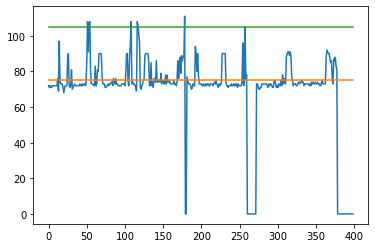

In [29]:
frame_len=320
frame_shift = 160
batch_idx = 0
loss_list = ["MIMO_RI"]
for idx,_loss_flag in enumerate(loss_list):
    est_sig, fs = torchaudio.load(f'../signals/{tst}_rirs_dbg/loss_functions_comparison_2mic_reverb/est_{batch_idx}_{idx}_{_loss_flag}.wav')
    est_real_img = torch.stft(est_sig, frame_len, frame_shift, frame_len, torch.hamming_window(frame_len), center=False, return_complex=False)
    est_real_img = torch.permute(est_real_img, [0, 3, 2, 1])

    est_spec_cmplx = format_complex(est_real_img)

    est_ri_spec = est_spec_cmplx#[1:3,:,:]

    wt_est = get_wt(option, mix_spec_cmplx, est_spec_cmplx) #get_mask(mix_spec_cmplx, est_spec_cmplx) # # torch.tanh(        # #    torch.abs(est_spec_cmplx) #                                      
    est_f_doa, est_f_vals, est_utt_doa, _, est_freq_vals = gcc_phat_loc_orient(est_spec_cmplx, wt_est, 16000, frame_len, local_mic_pos, 
                                                                    local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)

    est_frm_Acc, failed_frms,_ = get_acc(tgt_sig_vad, est_f_doa, ref_f_doa, tol=tol, vad_th=0.6)

    #Utterance level
    doa_degrees = torch.rad2deg(doa[:,:,-1])[0,0]
    mix_utt_Acc = 1 if torch.abs(mix_utt_doa-doa_degrees) <= tol else 0 #tgt_utt_doa
    est_utt_Acc = 1 if torch.abs(est_utt_doa-doa_degrees) <= tol else 0 #tgt_utt_doa

    print(dataset_dtype, mix_frm_Acc, est_frm_Acc) #, mix_Acc, est_Acc)
    print(ref_f_doa[0], mix_utt_doa, est_utt_doa)

    plt.figure()
    plt.plot(est_f_doa)
    plt.plot(torch.abs(ref_f_doa))
    plt.plot(180-torch.abs(ref_f_doa))

In [19]:
loss_list[0]

'MIMO_RI'

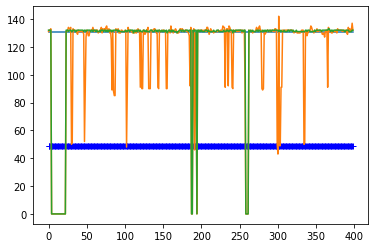

In [16]:
plt.plot(torch.abs(ref_f_doa))
plt.plot(180-torch.abs(ref_f_doa), 'b+')
plt.plot(est_f_doa_lst[0])
plt.plot(tgt_f_doa)
#plt.figure()
#plt.plot(torch.abs(ref_f_doa))
#plt.plot(180-torch.abs(ref_f_doa), 'b+')
#plt.plot(est_f_doa_lst[2])

In [ ]:
frm = 135
plt.plot(est_f_vals_lst[2][:,frm])

In [7]:
def get_mask(mix, est):
    noise = est - mix
    mask = torch.sqrt( torch.abs(est)**2/(torch.abs(noise)**2 + torch.abs(est)**2))
    return mask


In [8]:
def get_wt(option, mix, est):
    if option =="MASK":
        return get_mask(mix, est)
    elif option == "G_1":
        return torch.abs(est)
    else:
        print("Wrong option")


In [ ]:
def per_file_doa(batch_idx, option, tst, tol):
    print(batch_idx, option)
    frame_len, frame_shift = 320, 160
    idx_list = [0,1,2,3,4]

    mix_sig, fs = torchaudio.load(f'../signals/{tst}_rirs_dbg/loss_functions_comparison_4mic_diffuse_noisy_reverb/mix_{batch_idx}.wav')
    mix_real_img = torch.stft(mix_sig, frame_len, frame_shift, frame_len, torch.hamming_window(frame_len), center=False, return_complex=False)
    mix_real_img = torch.permute(mix_real_img, [0, 3, 2, 1])

    tgt_sig, fs = torchaudio.load(f'../signals/{tst}_rirs_dbg/loss_functions_comparison_4mic_diffuse_noisy_reverb/tgt_{batch_idx}.wav')
    tgt_real_img = torch.stft(tgt_sig, frame_len, frame_shift, frame_len, torch.hamming_window(frame_len), center=False, return_complex=False)
    tgt_real_img = torch.permute(tgt_real_img, [0, 3, 2, 1])

    mix_spec_cmplx = format_complex(mix_real_img)
    tgt_spec_cmplx = format_complex(tgt_real_img)

    ##extracting 2 channels
    mix_ri_spec = mix_spec_cmplx[1:3,:,:]
    tgt_ri_spec = tgt_spec_cmplx[1:3,:,:]

    #Vad 
    vad_comp_sig = tgt_sig

    sig_vad_1 = compute_vad(vad_comp_sig[0,:].cpu().numpy(), frame_len, frame_shift)
    sig_vad_2 = compute_vad(vad_comp_sig[1,:].cpu().numpy(), frame_len, frame_shift)
    tgt_sig_vad = sig_vad_1*sig_vad_2
    tgt_sig_vad = tgt_sig_vad.to(device=tgt_sig.device)


    euclid_dist=True
    mix_f_doa, mix_f_vals, mix_utt_doa, _, _ = gcc_phat_loc_orient(mix_spec_cmplx, torch.abs(mix_spec_cmplx), 16000, frame_len, local_mic_pos, 
                                                                    local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)

    wt_tgt = get_wt(option, mix_spec_cmplx, tgt_spec_cmplx) #torch.abs(tgt_spec_cmplx) #get_mask(mix_spec_cmplx, tgt_spec_cmplx) # #torch.tanh(
    tgt_f_doa, tgt_f_vals, tgt_utt_doa, _, tgt_freq_vals = gcc_phat_loc_orient(tgt_spec_cmplx, wt_tgt, 16000, frame_len, local_mic_pos, 
                                                                    local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)

    mix_frm_Acc,_ = get_acc(tgt_sig_vad, mix_f_doa, ref_f_doa, tol=tol, vad_th=0.6)

    for idx in idx_list:
        est_sig, fs = torchaudio.load(f'../signals/{tst}_rirs_dbg/loss_functions_comparison_4mic_diffuse_noisy_reverb/est_{batch_idx}_{idx}.wav')
        est_real_img = torch.stft(est_sig, frame_len, frame_shift, frame_len, torch.hamming_window(frame_len), center=False, return_complex=False)
        est_real_img = torch.permute(est_real_img, [0, 3, 2, 1])

        est_spec_cmplx = format_complex(est_real_img)

        est_ri_spec = est_spec_cmplx[1:3,:,:]

        wt_est = get_wt(option, mix_spec_cmplx, est_spec_cmplx) #torch.abs(est_spec_cmplx) # get_mask(mix_spec_cmplx, est_spec_cmplx) # # torch.tanh(                                                 
        est_f_doa, est_f_vals, est_utt_doa, _, est_freq_vals = gcc_phat_loc_orient(est_spec_cmplx, wt_est, 16000, frame_len, local_mic_pos, 
                                                                        local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)
    
        est_frm_Acc, failed_frms = get_acc(tgt_sig_vad, est_f_doa, ref_f_doa, tol=tol, vad_th=0.6)

        #Utterance level
        doa_degrees = torch.rad2deg(doa[:,:,-1])[0,0]
        mix_utt_Acc = 1 if torch.abs(mix_utt_doa-doa_degrees) <= tol else 0 #tgt_utt_doa
        est_utt_Acc = 1 if torch.abs(est_utt_doa-doa_degrees) <= tol else 0 #tgt_utt_doa

        print(dataset_dtype, mix_frm_Acc, est_frm_Acc) #, mix_Acc, est_Acc)
        print(ref_f_doa[0], mix_utt_doa, est_utt_doa)

        plt.figure()
        plt.plot(est_f_doa)
        plt.plot(torch.abs(ref_f_doa))
        plt.plot(180-torch.abs(ref_f_doa))

In [ ]:
#tol = 5.0
dataset_dtype = "stationary"
euclid_dist=True
(tst, tol, t60) = ("simu", 5.0, 1.0)
#(tst, tol,t60) = ("real", 7.5, 0.61)
sig_list = [3]
for batch_idx in sig_list:
    print(batch_idx, "G_0.3")
    for idx in range(5):
        info = torch.load(f'../signals/{tst}_rirs_dbg/loss_functions_comparison_4mic_diffuse_noisy_reverb/doa_{t60}_{batch_idx}_{idx}_tol_{tol}deg_euclid_{euclid_dist}.pt', map_location=torch.device('cpu')) #tr_s_test_{dataset_dtype}_{dataset_condition}_{t60}doa_{app_str}.pt')

        #ref_f_doa[0]

        (mix_f_doa, mix_f_vals, mix_utt_doa) = info['mix']
        (tgt_f_doa, tgt_f_vals, tgt_sig_vad, tgt_utt_doa) = info['tgt']
        (est_f_doa, est_f_vals, est_utt_doa) = info['est']

        doa = info['doa']
        ref_f_doa = torch.rad2deg(doa[:,:,-1])[0,:mix_f_doa.shape[0]]

        mix_frm_Acc,_ = get_acc(np.array(tgt_sig_vad), np.array(mix_f_doa), np.array(ref_f_doa),tol = tol, vad_th=0.6)
        est_frm_Acc, failed_frms = get_acc(np.array(tgt_sig_vad), np.array(est_f_doa), np.array(ref_f_doa),tol = tol, vad_th=0.6)
        
        print(dataset_dtype, mix_frm_Acc, est_frm_Acc) #, mix_Acc, est_Acc)
        print(ref_f_doa[0], mix_utt_doa, est_utt_doa)

    per_file_doa(batch_idx, "G_1", tst, tol)
    per_file_doa(batch_idx, "MASK", tst, tol)

In [11]:
frame_len, frame_shift = 320, 160
batch_idx_lst = [0,1,2,3,4]
options = ["MASK"] #,
loss_list = [ (3, "MIMO_RI_PD")] #, "MIMO_RI", "MIMO_RI_MAG", "MIMO_RI_MAG_PD", "MIMO_RI_PD_REF"]
#idx_list = [1,2] #[0,1,2,3,4]
dataset_dtype = "stationary"
euclid_dist=True
(tst, tol, t60, snr) = ("simu", 5.0, 1.0, 20.0)
folder = "loss_functions_comparison_2mic_noisy_ps"

#option = "G_1" #


for batch_idx in batch_idx_lst:
    info = torch.load(f'../signals/{tst}_rirs_dbg/{folder}/doa_{snr}_{batch_idx}_{0}_{"MIMO_RI"}_tol_{tol}deg_euclid_{euclid_dist}_wgt_mech_MASK.pt', map_location=torch.device('cpu')) #tr_s_test_{dataset_dtype}_{dataset_condition}_{t60}doa_{app_str}.pt')
    

    mix_sig, fs = torchaudio.load(f'../signals/{tst}_rirs_dbg/{folder}/mix_{batch_idx}.wav')
    mix_real_img = torch.stft(mix_sig, frame_len, frame_shift, frame_len, torch.hamming_window(frame_len), center=False, return_complex=False)
    mix_real_img = torch.permute(mix_real_img, [0, 3, 2, 1])

    tgt_sig, fs = torchaudio.load(f'../signals/{tst}_rirs_dbg/{folder}/tgt_{batch_idx}.wav')
    tgt_real_img = torch.stft(tgt_sig, frame_len, frame_shift, frame_len, torch.hamming_window(frame_len), center=False, return_complex=False)
    tgt_real_img = torch.permute(tgt_real_img, [0, 3, 2, 1])

    mix_spec_cmplx = format_complex(mix_real_img)
    tgt_spec_cmplx = format_complex(tgt_real_img)

    ##extracting 2 channels
    num_ch = mix_spec_cmplx.shape[0]
    if num_ch>2:
        mix_ri_spec = mix_spec_cmplx[1:3,:,:]
        tgt_ri_spec = tgt_spec_cmplx[1:3,:,:]
    else:
        mix_ri_spec = mix_spec_cmplx
        tgt_ri_spec = tgt_spec_cmplx
    #Vad 
    vad_comp_sig = tgt_sig
    #print(tgt_sig.shape)

    sig_vad_1 = compute_vad(vad_comp_sig[0,:].cpu().numpy(), frame_len, frame_shift)
    sig_vad_2 = compute_vad(vad_comp_sig[1,:].cpu().numpy(), frame_len, frame_shift)
    tgt_sig_vad = sig_vad_1*sig_vad_2
    tgt_sig_vad = tgt_sig_vad.to(device=tgt_sig.device)
    
    euclid_dist=True


    for option in options:
        wt_mix = get_wt(option, mix_ri_spec, mix_ri_spec)
        mix_f_doa, mix_f_vals, mix_utt_doa, _, _ = gcc_phat_loc_orient(mix_ri_spec, wt_mix, 16000, frame_len, local_mic_pos, 
                                                                    local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)
    
        doa = info['doa']
        ref_f_doa = torch.rad2deg(doa[:,:,-1])[0,:mix_f_doa.shape[0]]
        mix_frm_Acc,_, mix_mae_info = get_acc(tgt_sig_vad, mix_f_doa, ref_f_doa, tol=tol, vad_th=0.6)

        wt_tgt = get_wt(option, mix_ri_spec, tgt_ri_spec)#mix_spec_cmplx, tgt_spec_cmplx) #torch.abs(tgt_spec_cmplx) #get_mask(mix_spec_cmplx, tgt_spec_cmplx) # #torch.tanh(
        tgt_f_doa, tgt_f_vals, tgt_utt_doa, _, tgt_freq_vals = gcc_phat_loc_orient(tgt_ri_spec, wt_tgt, 16000, frame_len, local_mic_pos, 
                                                                        local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)

    for info_loss_flag in loss_list:
        idx, loss_flag = info_loss_flag
        est_sig, fs = torchaudio.load(f'../signals/{tst}_rirs_dbg/{folder}/est_{batch_idx}_{idx}_{loss_flag}.wav')
        est_real_img = torch.stft(est_sig, frame_len, frame_shift, frame_len, torch.hamming_window(frame_len), center=False, return_complex=False)
        est_real_img = torch.permute(est_real_img, [0, 3, 2, 1])

        est_spec_cmplx = format_complex(est_real_img)

        if num_ch>2:
            est_ri_spec = est_spec_cmplx[1:3,:,:]
        else:
            est_ri_spec = est_spec_cmplx

            
        for option in options:
            wt_est = get_wt(option, mix_ri_spec, est_ri_spec)#mix_spec_cmplx, est_spec_cmplx) #torch.abs(est_spec_cmplx) # get_mask(mix_spec_cmplx, est_spec_cmplx) # # torch.tanh(                                                 
            est_f_doa, est_f_vals, est_utt_doa, _, est_freq_vals = gcc_phat_loc_orient(est_ri_spec, wt_est, 16000, frame_len, local_mic_pos, 
                                                                            local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)
        
            est_frm_Acc, failed_frms, est_mae_info = get_acc(tgt_sig_vad, est_f_doa, ref_f_doa, tol=tol, vad_th=0.6)

            #Utterance level
            doa_degrees = torch.rad2deg(doa[:,:,-1])[0,0]
            mix_utt_Acc = 1 if torch.abs(mix_utt_doa-doa_degrees) <= tol else 0 #tgt_utt_doa
            est_utt_Acc = 1 if torch.abs(est_utt_doa-doa_degrees) <= tol else 0 #tgt_utt_doa

            print(dataset_dtype,loss_flag, mix_frm_Acc, est_frm_Acc, mix_mae_info, est_mae_info) #, mix_Acc, est_Acc)
            print(loss_flag, ref_f_doa[0], mix_utt_doa, est_utt_doa)

            plt.figure()
            plt.title(f'{batch_idx}_{idx}_{loss_flag}_{option}')
            plt.plot(mix_f_doa,'b')
            plt.plot(est_f_doa, 'r')
            plt.plot(torch.abs(ref_f_doa))
            plt.plot(180-torch.abs(ref_f_doa))

KeyboardInterrupt: 

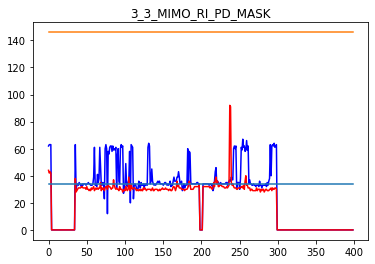

In [10]:
plt.figure()
plt.title(f'{batch_idx}_{idx}_{loss_flag}_{option}')
plt.plot(mix_f_doa,'b')
plt.plot(est_f_doa, 'r')
plt.plot(torch.abs(ref_f_doa))
plt.plot(180-torch.abs(ref_f_doa))

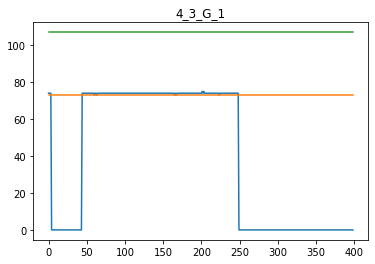

In [25]:
plt.title(f'{batch_idx}_{idx}_{option}')
plt.plot(tgt_f_doa)
plt.plot(torch.abs(ref_f_doa))
plt.plot(180-torch.abs(ref_f_doa))

In [ ]:
np.array(failed_frms)

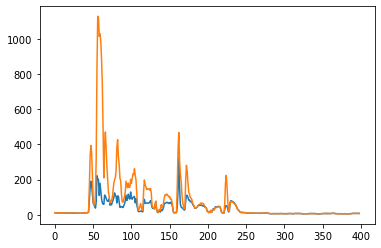

In [26]:
#loss
loss_ri = torch.sum(torch.sum(torch.abs(est_ri_spec - tgt_ri_spec), dim=0), dim=1)/160

#perm
est_ri_spec_perm = torch.concat((est_ri_spec[[1]], est_ri_spec[[0]]))
loss_perm_ri = torch.sum(torch.sum(torch.abs(est_ri_spec_perm - tgt_ri_spec), dim=0), dim=1)/160

plt.plot(loss_ri*180)
plt.plot(loss_perm_ri*180)


tensor(74) tensor(88)


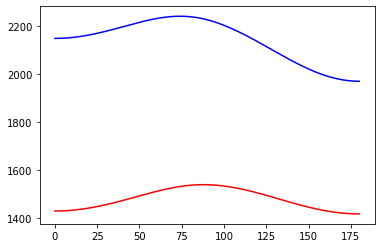

In [27]:
frm = 50
print(np.argmax(tgt_f_vals[:,frm]), np.argmax(est_f_vals[:,frm]))
plt.plot(tgt_f_vals[:,frm], 'b')
#plt.figure()
plt.plot(est_f_vals[:,frm], 'r')

torch.Size([399, 161])

In [28]:
tgt_mask = wt_tgt[0]*wt_tgt[1]
est_mask = wt_est[0]*wt_est[1]

In [29]:
est_mag_1, est_ph_1, est_mag_2, est_ph_2 = get_mag_ph(est_real_img)
tgt_mag_1, tgt_ph_1, tgt_mag_2, tgt_ph_2 = get_mag_ph(tgt_real_img)
mix_mag_1, mix_ph_1, mix_mag_2, mix_ph_2 = get_mag_ph(mix_real_img)

<module 'matplotlib.pyplot' from '/users/PAS1937/battula12/my_pkgs/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

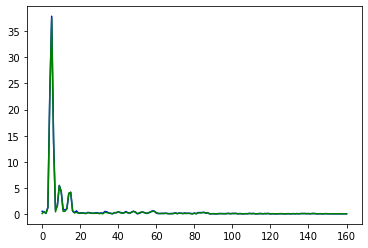

In [30]:
plt.plot(mix_mag_1[frm,:], 'b')
plt.plot(tgt_mag_1[frm,:], 'g')
plt

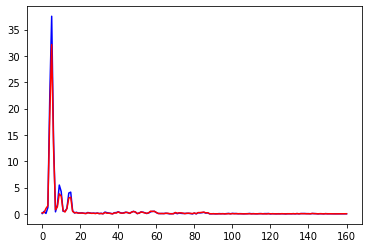

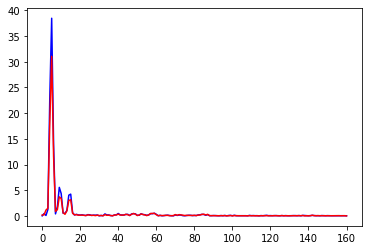

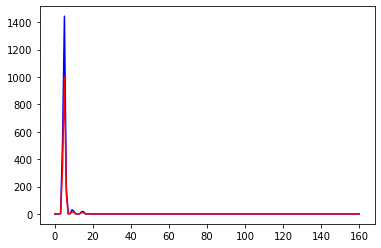

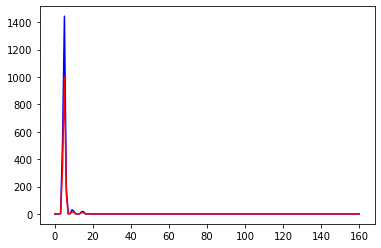

In [31]:
plt.plot(tgt_mag_1[frm,:], 'b')
plt.plot(est_mag_1[frm,:], 'r')
plt.figure()
plt.plot(tgt_mag_2[frm,:], 'b')
plt.plot(est_mag_2[frm,:], 'r')
plt.figure()
plt.plot(tgt_mask[frm,:], 'b')
plt.plot(est_mask[frm,:], 'r')
plt.figure()
plt.plot(tgt_mag_1[frm,:]*tgt_mag_2[frm,:], 'b')
plt.plot(est_mag_1[frm,:]*est_mag_2[frm,:], 'r')


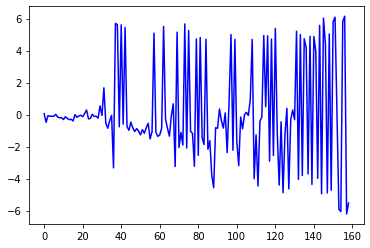

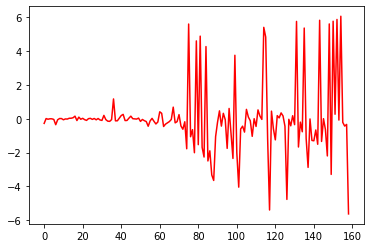

In [32]:
plt.figure()
plt.plot(tgt_ph_1[frm,:]-tgt_ph_2[frm,:], 'b')
plt.figure()
plt.plot(est_ph_1[frm,:]-est_ph_2[frm,:], 'r')

In [ ]:
plt.figure()
plt.plot((tgt_mask[frm,1:160]*(tgt_ph_1[frm,:]-tgt_ph_2[frm,:])), 'b')
plt.plot((est_mask[frm,1:160]*(est_ph_1[frm,:]-est_ph_2[frm,:])), 'r')
plt.figure()
plt.plot(tgt_mask[frm,1:160]*(tgt_ph_1[frm,:]-tgt_ph_2[frm,:]), 'b')
plt.plot(est_mask[frm,1:160]*-1*(est_ph_1[frm,:]-est_ph_2[frm,:]), 'r')

In [ ]:
est_real_img[1,:,frm,:][:,:25],tgt_real_img[1,:,frm,:][:,:25]

In [ ]:
euclid_dist=True
mix_f_doa, mix_f_vals, mix_utt_doa, _, _ = gcc_phat_loc_orient(mix_spec_cmplx, torch.abs(mix_spec_cmplx), 16000, frame_len, local_mic_pos, 
                                                                local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)

wt_tgt = torch.abs(tgt_spec_cmplx) #get_mask(mix_spec_cmplx, tgt_spec_cmplx) #torch.tanh(
tgt_f_doa, tgt_f_vals, tgt_utt_doa, _, tgt_freq_vals = gcc_phat_loc_orient(tgt_spec_cmplx, wt_tgt, 16000, frame_len, local_mic_pos, 
                                                                local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)

wt_est = torch.abs(est_spec_cmplx) #get_mask(mix_spec_cmplx, est_spec_cmplx)     # torch.tanh(                                                 
est_f_doa, est_f_vals, est_utt_doa, _, est_freq_vals = gcc_phat_loc_orient(est_spec_cmplx, wt_est, 16000, frame_len, local_mic_pos, 
                                                                local_mic_center, src_mic_dist=1, weighted=True, sig_vad=tgt_sig_vad, is_euclidean_dist=euclid_dist)


mix_frm_Acc,_ = get_acc(tgt_sig_vad, mix_f_doa, ref_f_doa, tol=tol, vad_th=0.6)
est_frm_Acc, failed_frms = get_acc(tgt_sig_vad, est_f_doa, ref_f_doa, tol=tol, vad_th=0.6)

#Utterance level
doa_degrees = torch.rad2deg(doa[:,:,-1])[0,0]
mix_utt_Acc = 1 if torch.abs(mix_utt_doa-doa_degrees) <= tol else 0 #tgt_utt_doa
est_utt_Acc = 1 if torch.abs(est_utt_doa-doa_degrees) <= tol else 0 #tgt_utt_doa

print(dataset_dtype, mix_frm_Acc, est_frm_Acc) #, mix_Acc, est_Acc)
print(ref_f_doa[0], mix_utt_doa, est_utt_doa)

In [ ]:
frm = 135
plt.plot(est_f_vals[:,frm])

In [ ]:
plt.plot(est_f_doa)
plt.plot(ref_f_doa)

#
\gamma = 1 \
stationary 0.19946091644204852 0.18598382749326145 \
tensor(75.) tensor(86.) tensor(78.) \
stationary 0.19946091644204852 0.20485175202156333 \
tensor(75.) tensor(86.) tensor(78.) \
stationary 0.19946091644204852 0.6361185983827493 \
tensor(75.) tensor(86.) tensor(73.) \
stationary 0.19946091644204852 0.7520215633423181 \
tensor(75.) tensor(86.) tensor(73.) \
stationary 0.19946091644204852 0.5902964959568733 \
tensor(75.) tensor(86.) tensor(74.) 

#
\gamma = 0.3
stationary 0.16981132075471697 0.16711590296495957 \
tensor(75.) tensor(85.) tensor(84.) \
stationary 0.16981132075471697 0.2830188679245283 \
tensor(75.) tensor(85.) tensor(76.) \
stationary 0.16981132075471697 0.6199460916442049 \
tensor(75.) tensor(85.) tensor(73.) \
stationary 0.16981132075471697 0.3584905660377358 \
tensor(75.) tensor(85.) tensor(74.) \
stationary 0.16981132075471697 0.16442048517520216 \
tensor(75.) tensor(85.) tensor(75.)